# FEATURE EXTRACTION FROM AUDIO (EXPORT TO CSV)

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ravdess-emotional-speech-audio:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F107620%2F256618%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240613%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240613T054812Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7dee96f642bbda8671a850a60839ca83bc147f0f1ce38564053aa05ffc629bc941a889cfa55a01b6992258480659d2a23dbaf59fbd83a5369f131434da4749a6625c9703e6136a6592000f02d175842ae5e7b2548d6163820ab877b16c94da44e7370a8f1e4a54cdc29b0ef671cea4319b7f98ff7c0f36d2c4b0e515e23963f3a011be062d2eb032d7f84a11cdfd9ca4fc20280611588b9237c327e939c52f39df5a539a839f76a18ad589eafa99aeaaeac322dbebad2cc1be7fc0b75bc3b3f616fada4f4a5bed3833d4775e4908038ef24bff57a191f3071714a09e66e9296b15d5d8e498836c2437855e45266739af401ad27ba8258d818809a53ea3d1da54,toronto-emotional-speech-set-tess:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F316368%2F639622%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240613%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240613T054813Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D003c954154b4ef6e5020c3a9f1dfafb7986d08473c3a9f4d2c8c575123175588e5558a4fb9af47c205c60e74e7b560e863da2f49c71da3571c042f1434e8d5cf4c0faba5ac77e0ddc50b4edda1d1251de7639b003acbd3df1ce3757a85f908027d976515da432a757d9d1c3045712b65700f5f395284f2794506159389482b8244a5e37c7aa03a91529cf82f4e29835e16a3d1c39a2fae5b519690562240c1f7185673edeb2f3d718a86a69867e88bd468f2a153d131e6b7a1bc26ea78b1c07c940d621f514dd8f802b9e46831411162dd0387182347945252523d928ad5bb4cf859659277782f6d24afef142c9baef7d6043a1fb5ced2fc3b56ea6402f6e6ae'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

from IPython.display import Audio

# 1. Data Preparation


## Filename identifiers

- **Modality** (01 = full-AV, 02 = video-only, 03 = audio-only).

- **Vocal channel** (01 = speech, 02 = song).

On this dataset, there are just audio-only and speech so the format is 03-01-.... and so on

- **Emotion** (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

- **Emotional intensity** (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

- **Statement** (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

- **Repetition** (01 = 1st repetition, 02 = 2nd repetition).

- **Actor** (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: *03-01-06-01-02-01-12.wav*:


Audio-only (03),
Speech (01),
Fearful (06),
Normal intensity (01),
Statement "dogs" (02),
1st Repetition (01),
12th Actor (12),
Female, as the actor ID number is even.

In [ ]:
os.listdir("/kaggle/input/ravdess-emotional-speech-audio/")

['Actor_02',
 'Actor_17',
 'Actor_05',
 'Actor_16',
 'Actor_21',
 'Actor_01',
 'Actor_11',
 'Actor_20',
 'Actor_08',
 'Actor_15',
 'Actor_06',
 'Actor_12',
 'Actor_23',
 'Actor_24',
 'Actor_22',
 'Actor_04',
 'Actor_19',
 'Actor_10',
 'Actor_09',
 'audio_speech_actors_01-24',
 'Actor_14',
 'Actor_03',
 'Actor_13',
 'Actor_18',
 'Actor_07']

In [ ]:
os.listdir("/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/")

['Actor_02',
 'Actor_17',
 'Actor_05',
 'Actor_16',
 'Actor_21',
 'Actor_01',
 'Actor_11',
 'Actor_20',
 'Actor_08',
 'Actor_15',
 'Actor_06',
 'Actor_12',
 'Actor_23',
 'Actor_24',
 'Actor_22',
 'Actor_04',
 'Actor_19',
 'Actor_10',
 'Actor_09',
 'Actor_14',
 'Actor_03',
 'Actor_13',
 'Actor_18',
 'Actor_07']

In [ ]:
os.listdir('/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data')

['YAF_fear',
 'OAF_angry',
 'OAF_Fear',
 'OAF_disgust',
 'OAF_neutral',
 'YAF_angry',
 'OAF_Sad',
 'YAF_disgust',
 'YAF_neutral',
 'OAF_Pleasant_surprise',
 'YAF_happy',
 'OAF_happy',
 'YAF_sad',
 'YAF_pleasant_surprised']

In [ ]:
ravdess_path = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
tess_path = "/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data"

## DataFrame RAVDESS

In [ ]:
ravdess_dir_list = os.listdir(ravdess_path)

file_emotion = []
file_path = []
for dir in ravdess_dir_list:
    # mengekstrak tiap file dari tiap aktor
    actor = os.listdir(ravdess_path + dir)
    for file in actor:
        # mendapatkan filename dengan memisahkannya dengan format .wav
        part = file.split('.')[0]
        # mendapatkan format nama dari filename yg dipisahkan dengan tanda "-"
        part = part.split('-')
        # indeks ke-2 mengartikan jenis emosi. lalu append ke list
        file_emotion.append(part[2])
        # append indeks file dari emosi tersebut
        file_path.append(ravdess_path + dir + '/' + file)

# dataframe file emotion
emotion_df = pd.DataFrame(file_emotion, columns=['emotions'])
emotion_df = emotion_df.replace({'01':'neutral', '02':'calm', '03':'happy', '04':'sad', '05':'angry', '06':'fear', '07':'disgust', '08':'surprise'})

# dataframe path file
path_df = pd.DataFrame(file_path, columns=['path'])
Ravdess_DF = pd.concat([emotion_df, path_df], axis=1)

# convert
Ravdess_DF.head(7)

,emotions,path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
5,fear,/kaggle/input/ravdess-emotional-speech-audio/a...
6,sad,/kaggle/input/ravdess-emotional-speech-audio/a...


## DataFrame TESS

In [ ]:
tess_directory_list = os.listdir(tess_path)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(tess_path + "/" + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(tess_path + '/' + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_DF = pd.concat([path_df, emotion_df], axis=1)
Tess_DF

,Path,Emotions
0,/kaggle/input/toronto-emotional-speech-set-tes...,fear
1,/kaggle/input/toronto-emotional-speech-set-tes...,fear
2,/kaggle/input/toronto-emotional-speech-set-tes...,fear
3,/kaggle/input/toronto-emotional-speech-set-tes...,fear
4,/kaggle/input/toronto-emotional-speech-set-tes...,fear
...,...,...
2795,/kaggle/input/toronto-emotional-speech-set-tes...,surprise
2796,/kaggle/input/toronto-emotional-speech-set-tes...,surprise
2797,/kaggle/input/toronto-emotional-speech-set-tes...,surprise
2798,/kaggle/input/toronto-emotional-speech-set-tes...,surprise


In [ ]:
Tess_DF[Tess_DF["Emotions"]=="surprise"]

,Path,Emotions
1800,/kaggle/input/toronto-emotional-speech-set-tes...,surprise
1801,/kaggle/input/toronto-emotional-speech-set-tes...,surprise
1802,/kaggle/input/toronto-emotional-speech-set-tes...,surprise
1803,/kaggle/input/toronto-emotional-speech-set-tes...,surprise
1804,/kaggle/input/toronto-emotional-speech-set-tes...,surprise
...,...,...
2795,/kaggle/input/toronto-emotional-speech-set-tes...,surprise
2796,/kaggle/input/toronto-emotional-speech-set-tes...,surprise
2797,/kaggle/input/toronto-emotional-speech-set-tes...,surprise
2798,/kaggle/input/toronto-emotional-speech-set-tes...,surprise


In [ ]:
Tess_DF["Path"][1]
# /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_deep_fear.wav


'/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_youth_fear.wav'

## Fungsi untuk memvisualisasikan data audio

In [ ]:
def create_waveplot(data, samplingrate, emotion):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(emotion), size=15)
    librosa.display.waveshow(data, sr=samplingrate)
    plt.show()

def create_spectrogram(data, samplingrate, emotion):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(emotion), size=15)
    librosa.display.specshow(Xdb, sr=samplingrate, x_axis='time', y_axis='hz')
    plt.colorbar()


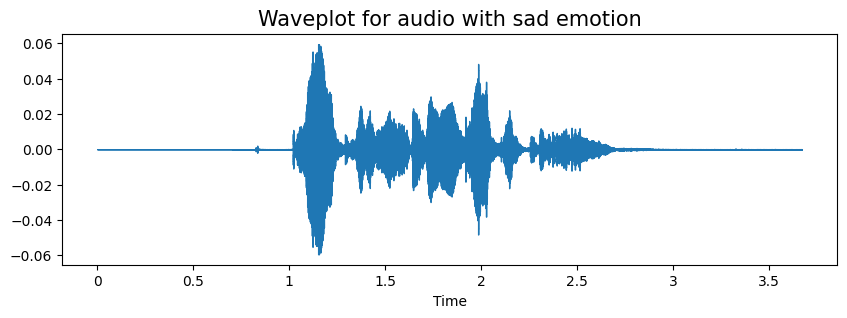

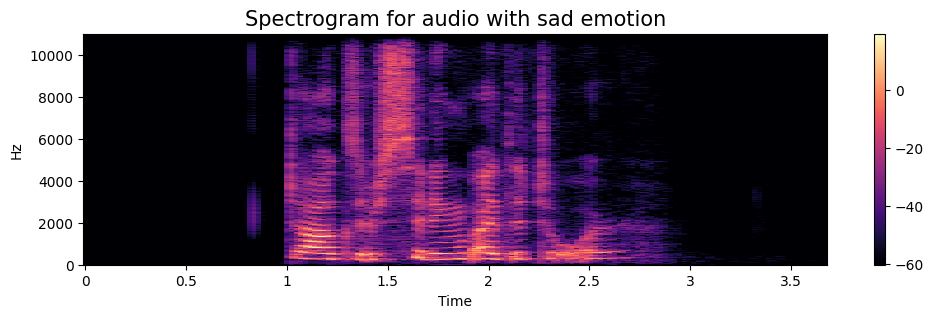

In [ ]:
emotion='sad'
path = np.array(Ravdess_DF.path[Ravdess_DF.emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

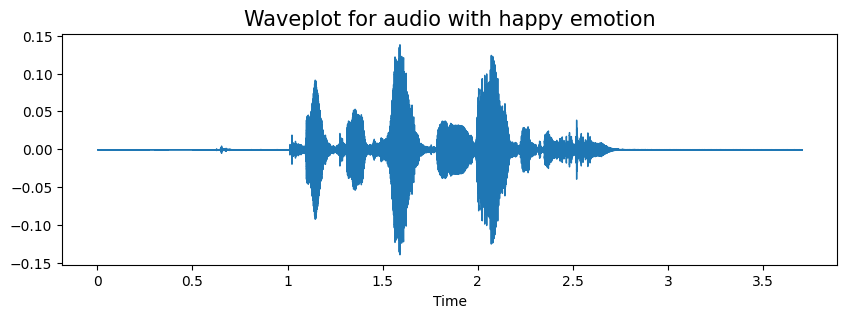

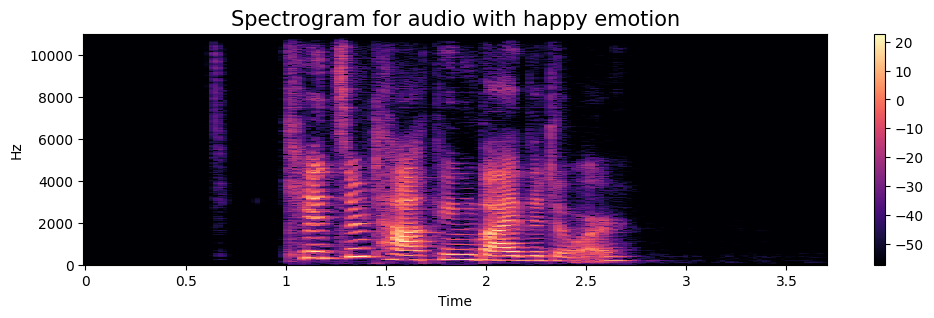

In [ ]:
emotion='happy'
path = np.array(Ravdess_DF.path[Ravdess_DF.emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

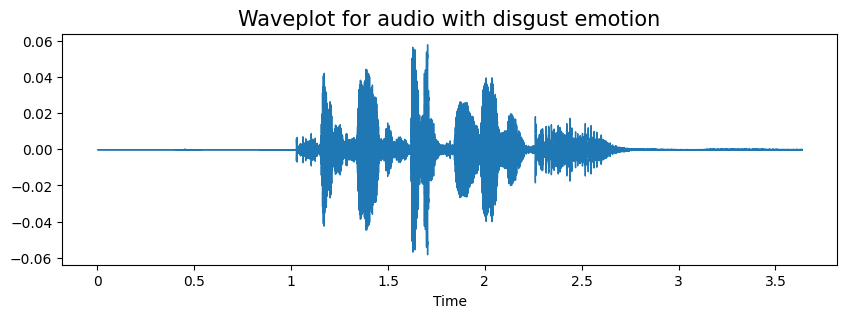

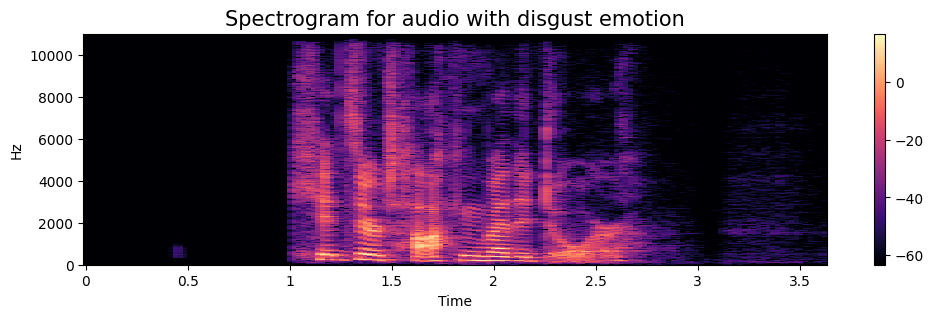

In [ ]:
emotion='disgust'
path = np.array(Ravdess_DF.path[Ravdess_DF.emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

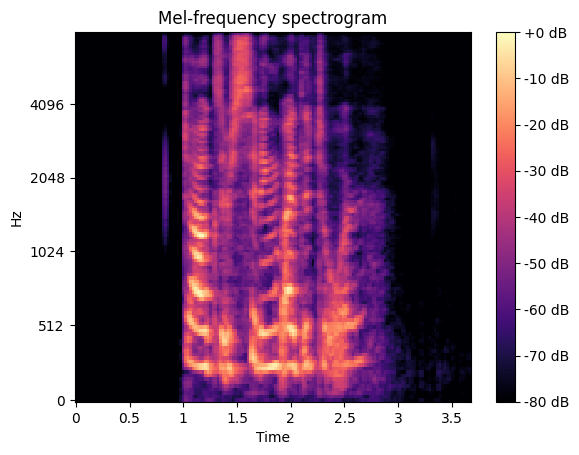

In [ ]:
emotion='sad'
path = np.array(Ravdess_DF.path[Ravdess_DF.emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
melspectro = librosa.feature.melspectrogram(y=data, sr=sampling_rate)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(melspectro, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sampling_rate,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-03-01-01-02-02.wav


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

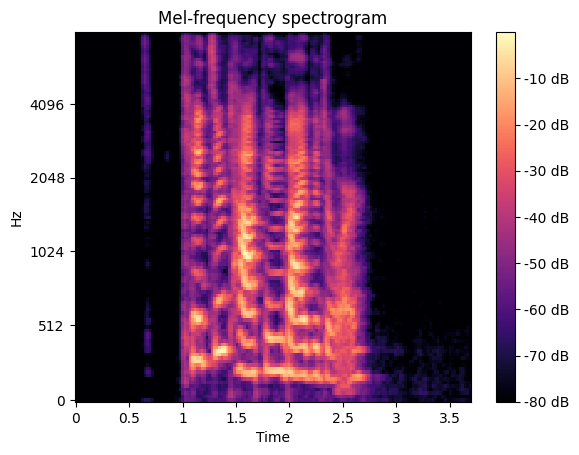

In [ ]:
emotion='happy'
path = np.array(Ravdess_DF.path[Ravdess_DF.emotions==emotion])[1]
print(path)
data, sampling_rate = librosa.load(path)
melspectro = librosa.feature.melspectrogram(y=data, sr=sampling_rate)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(melspectro, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sampling_rate,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_happy/YAF_pearl_happy.wav


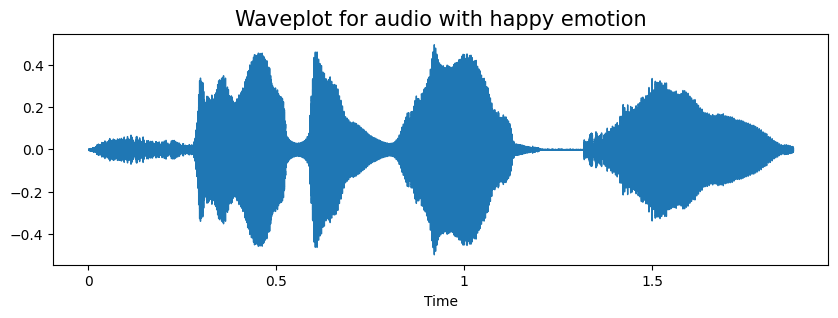

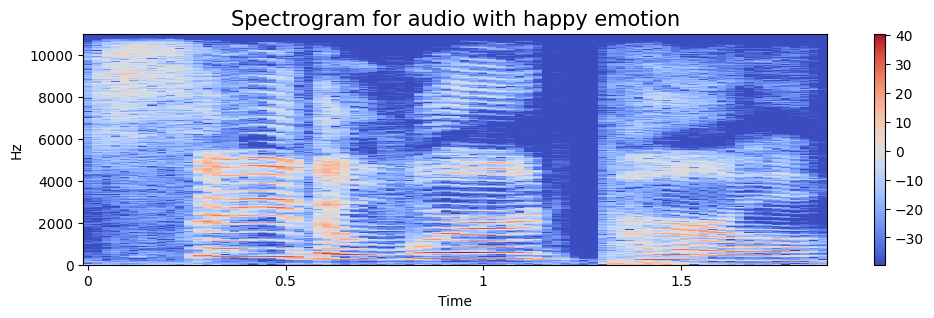

In [ ]:
emotion='happy'
path = np.array(Tess_DF.Path[Tess_DF.Emotions==emotion])[1]
print(path)
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# 2. Data preprocessing & Features Extraction

## Data Augmentation

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data):
    return librosa.effects.time_stretch(data, rate=0.8)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=-4)

# taking any example and checking for techniques.
path = np.array(Ravdess_DF.path)[1]
data, sample_rate = librosa.load(path)

In [ ]:
np.array(Ravdess_DF.path)[2]

'/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-07-02-01-02-02.wav'

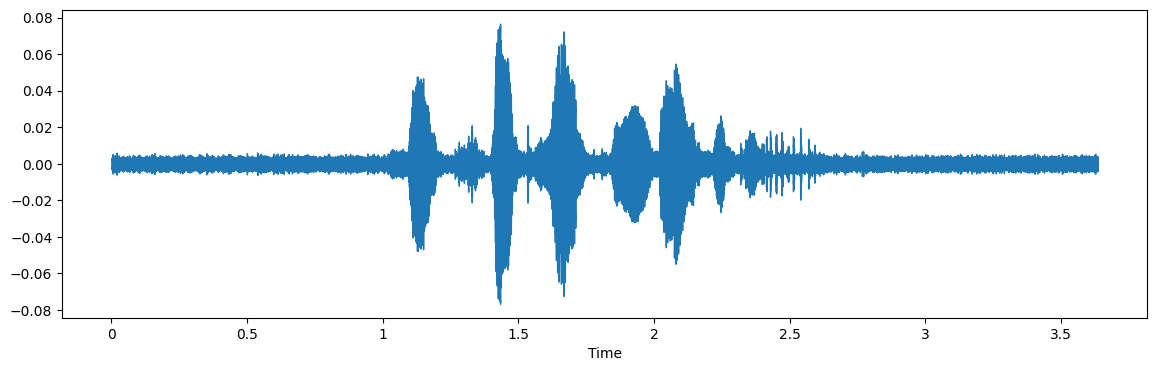

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

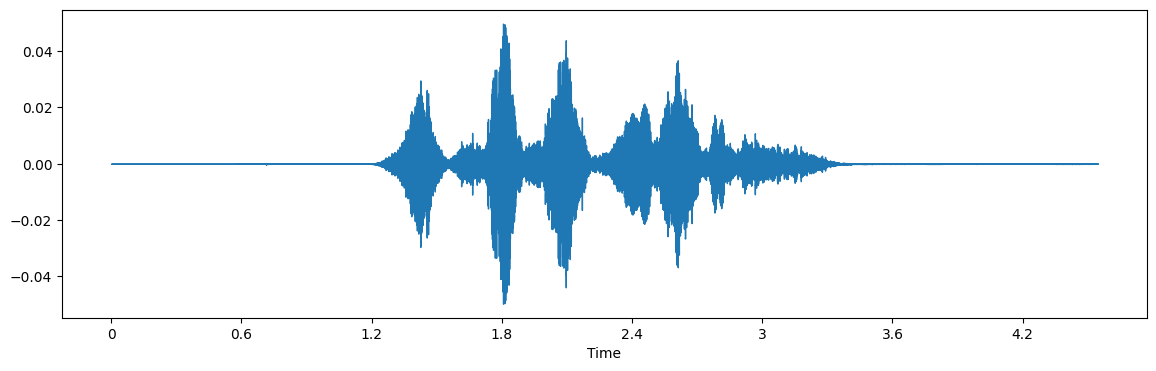

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

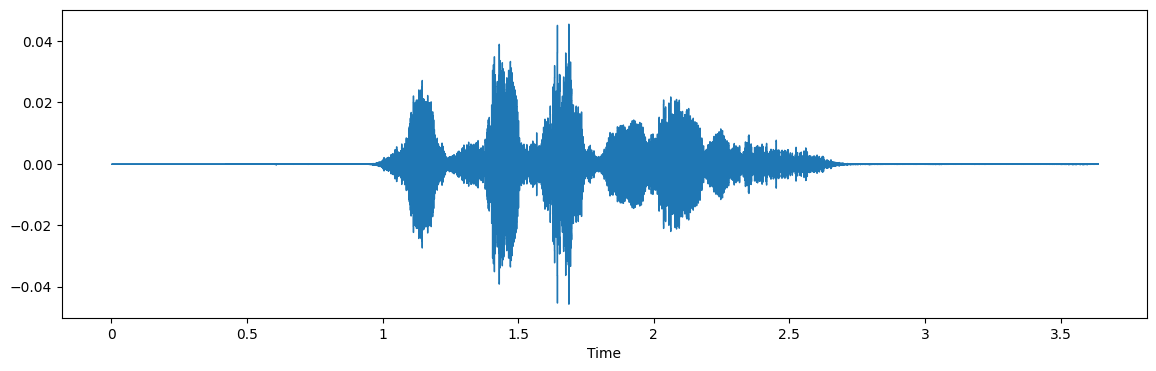

In [ ]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

## Fungsi untuk ekstraksi fitur

In [ ]:
# Function untuk ekstraksi fitur-fitur dari audio
def extract_features(data, sample_rate):
  # 1. MFCC
  mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)

  # 2. chroma_stft
  stft =  np.abs(librosa.stft(data))
  chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)

  # 3. Mel spectogram
  mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)

  # 4. zero crossing rate
  zcr = np.mean(librosa.feature.zero_crossing_rate(y=data, frame_length=2048, hop_length=512).T, axis=0)

  # 5. RMS
  rms = np.mean(librosa.feature.rms(y=data, frame_length=2048, hop_length=512).T, axis=0)

  features = np.hstack([mfcc, chroma_stft, mel, zcr, rms])

  return features

# Apply fungsi ke semua audio
def get_features(path):
  data, sample_rate = librosa.load(path)

  # ekstrak fitur dari base audio
  base = extract_features(data, sample_rate)

  # apply noise ke data
  noise_data = noise(data)
  # ekstrak fitur dari data yang noise
  noise_features = extract_features(noise_data, sample_rate)

  # apply pitch shift ke data
  pitch_data = pitch(data, sample_rate)
  # ekstrak fitur
  pitch_features = extract_features(pitch_data, sample_rate)

  # Concatenate all features
  all_features = np.vstack([base, noise_features, pitch_features])

  return pd.DataFrame(all_features)

## RAVDESS features extraction

In [ ]:
features_list, labels_list = [], []

# iterasi dari setiap audio dan emosinya
for path, emotion in zip(Ravdess_DF['path'], Ravdess_DF['emotions']):
  # ekstraksi fitur dan label dari data asli dan yg teraugmentasi
  features = get_features(path)

  # meng-append baris-baris baru
  features_list.append(features)
  labels_list.extend([emotion] * len(features))

## TESS features extraction

In [ ]:
features_list2, labels_list2 = [], []

# iterasi dari setiap audio dan emosinya
for path, emotion in zip(Tess_DF['path'], Tess_DF['emotions']):
  # ekstraksi fitur dari data asli dan yg teraugmentasi
  features = get_features(path)

  # meng-append baris-baris baru
  features_list2.append(features)
  labels_list2.extend([emotion] * len(features))

# Final dataset

Penggabungan hasil ekstraksi pada data RAVDESS dan TESS

In [ ]:
# penggabungan semua fitur dari RAVDESS+TESS
all_features = pd.concat([features_list, features_list2], ignore_index=True)

# Label dari RAVDESS+TESS
labels_df = pd.DataFrame([labels_list, labels_list2], columns=['emotion'])

# penggabungan fitur+label
final_df = pd.concat([all_features.reset_index(drop=True), labels_df.reset_index(drop=True)], axis=1)

final_df.head(7)

In [ ]:
final_df.shape

In [ ]:
final_df.isna().sum()

In [ ]:
# df3 = final_df.dropna()
# df3

# Saving dataset

In [ ]:
final_df.to_csv('data.csv', index=False)